In [10]:
import serial
import datetime
port1 = "/dev/tty.usbmodem101"
port2 = "/dev/tty.usbmodem2101"

In [11]:
filename = datetime.datetime.utcnow().strftime("data/gps_data_%Y%m%d-%H%M%S.nmea")
filename = "data/jon_gps.nmea"
f = open(filename, "ab")

try:
    ser = serial.Serial(port1, baudrate=9600)
except:
    ser = serial.Serial(port2, baudrate=9600)
ser.flushInput()
ser.flushOutput()
idx = 0

nmea_data = b""

# skip first line, since it could be incomplete
ser.readline()

while idx <= 200000:
    idx += 1
    nmea_sentence = ser.readline()
    #print(nmea_sentence)
    nmea_data += nmea_sentence

    if idx % 2000 == 0:
        print(f"idx: {idx}")
        f.write(nmea_data)
        nmea_data = b""
        
f.close()

idx: 2000
idx: 4000
idx: 6000
idx: 8000
idx: 10000
idx: 12000
idx: 14000
idx: 16000
idx: 18000
idx: 20000
idx: 22000
idx: 24000
idx: 26000
idx: 28000
idx: 30000
idx: 32000
idx: 34000
idx: 36000
idx: 38000
idx: 40000
idx: 42000
idx: 44000
idx: 46000
idx: 48000
idx: 50000
idx: 52000
idx: 54000
idx: 56000
idx: 58000
idx: 60000
idx: 62000
idx: 64000


KeyboardInterrupt: 

In [12]:
try: 
    import pynmea2
except:
    %pip install pynmea2
    import pynmea2
    
nmea_data = open(filename, "rb")
for message_bytes in nmea_data.readlines()[:10]: # read first 10 messages from file
    try:
        message = message_bytes.decode("utf-8").replace("\n", "").replace("\r", "")
        parsed_message = pynmea2.parse(message)
    except:
        # skip invalid messages
        continue
        
    print(f"message: {message}")

    for field in parsed_message.fields:
        value = getattr(parsed_message, field[1])
        print(f"{field[0]:40} {field[1]:20} {value}")
    
    print("\n")

message: $GPTXT,01,01,02,HW  UBX-G70xx   00070000 *77
Number of Messages                       num_msg              01
Message Number                           msg_num              01
Type of Message                          msg_type             02
Text                                     text                 HW  UBX-G70xx   00070000 


message: $GPTXT,01,01,02,ROM CORE 1.00 (59842) Jun 27 2012 17:43:52*59
Number of Messages                       num_msg              01
Message Number                           msg_num              01
Type of Message                          msg_type             02
Text                                     text                 ROM CORE 1.00 (59842) Jun 27 2012 17:43:52


message: $GPTXT,01,01,02,PROTVER 14.00*1E
Number of Messages                       num_msg              01
Message Number                           msg_num              01
Type of Message                          msg_type             02
Text                                     text      

In [13]:
coordinates_data = []
nmea_data = open(filename, "rb")

for message_bytes in nmea_data.readlines():    
    try:
        message = message_bytes.decode("utf-8").replace("\n", "").replace("\r", "")
        parsed_message = pynmea2.parse(message)
    except:
        # skip invalid sentences
        continue

    cga_data = {}
    
    # process only GGA messages
    if parsed_message.sentence_type == "GGA":
        for attr in ["timestamp", "latitude", "longitude", "latitude", "horizontal_dil", "num_sats", "gps_qual"]:
            cga_data[attr] = getattr(parsed_message, attr)
        coordinates_data.append(cga_data)
        
coordinates_data[0]

{'timestamp': datetime.time(13, 25, 18, tzinfo=datetime.timezone.utc),
 'latitude': 42.421048166666665,
 'longitude': -71.18579133333333,
 'horizontal_dil': '1.00',
 'num_sats': '09',
 'gps_qual': 1}

In [14]:
import pandas as pd
try: 
    import geopandas as gpd
except:
    %pip install geopandas
    import geopandas as gpd

df = pd.DataFrame(coordinates_data)
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude, crs="EPSG:4326"))
gdf

,timestamp,latitude,longitude,horizontal_dil,num_sats,gps_qual,geometry
0,13:25:18+00:00,42.421048,-71.185791,1.00,09,1,POINT (-71.18579 42.42105)
1,13:25:19+00:00,42.421047,-71.185792,1.00,09,1,POINT (-71.18579 42.42105)
2,13:25:20+00:00,42.421046,-71.185792,1.00,09,1,POINT (-71.18579 42.42105)
3,13:25:21+00:00,42.421045,-71.185793,1.00,09,1,POINT (-71.18579 42.42104)
4,13:25:22+00:00,42.421044,-71.185793,1.00,09,1,POINT (-71.18579 42.42104)
...,...,...,...,...,...,...,...
9731,16:20:07+00:00,42.421101,-71.185853,1.04,09,1,POINT (-71.18585 42.42110)
9732,16:20:08+00:00,42.421099,-71.185852,1.04,09,1,POINT (-71.18585 42.42110)
9733,16:20:09+00:00,42.421097,-71.185852,1.04,09,1,POINT (-71.18585 42.42110)
9734,16:20:10+00:00,42.421095,-71.185851,1.04,09,1,POINT (-71.18585 42.42109)


In [15]:
import matplotlib.pyplot as plt
try: 
    import contextily as ctx
except:
    %pip install contextily
    import contextily as ctx

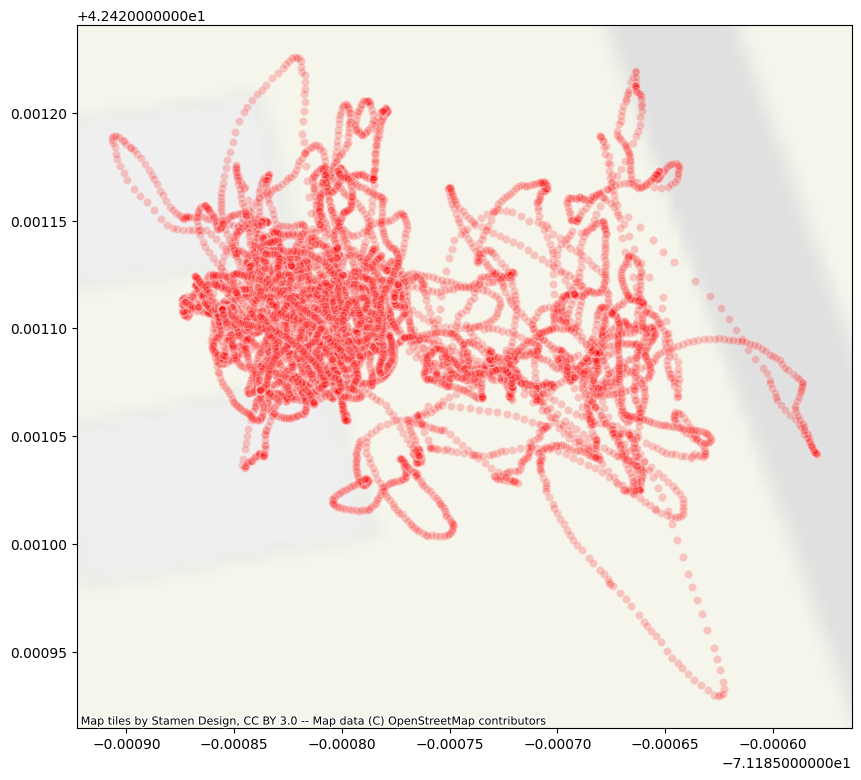

In [16]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes()
gdf[gdf.gps_qual > 0].plot(ax=ax, alpha=.2, edgecolor="#ffff", color='red')
ctx.add_basemap(ax, url=ctx.providers.Stamen.TonerLite, crs="EPSG:4326", alpha=.3, zoom=18)
#ctx.add_basemap(ax, url=ctx.providers.Stamen.TonerLite)